## **Fine tuning the pre-trained models for image classification**

In [45]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import cv2

import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam,SGD

tf.random.set_seed(2525)

import warnings
warnings.filterwarnings('ignore')

### Download the dataset

In [46]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2022-05-31 14:23:29--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.136.128, 142.250.148.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.136.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   241MB/s    in 0.3s    

2022-05-31 14:23:30 (241 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



### Preparing the dataset

We first divide the folder into train and validation directories. Then, each of the directory create a separate directory for cats having only cat images and create a separate directory for dog having only dog images

In [47]:
saved_dir = '/tmp/cats_and_dogs_filtered.zip'
read_zip = zipfile.ZipFile(saved_dir,'r')
read_zip.extractall('/tmp')
read_zip.close()

In [48]:
base_dir = '/tmp/cats_and_dogs_filtered'

## Directory for our training images
train_dir = os.path.join(base_dir,'train')
## Directory for our validation images
valid_dir = os.path.join(base_dir,'validation')

## Directory for our cat training images
train_cats_dir = os.path.join(train_dir,'cats')
## Directory for our dog training images
train_dogs_dir = os.path.join(train_dir,'dogs')

## Directory for our cat validation images
valid_cats_dir = os.path.join(valid_dir,'cats')
## Directory for our dog validation images
valid_dogs_dir = os.path.join(valid_dir,'dogs')


We will check whether images loaded properly into the directory

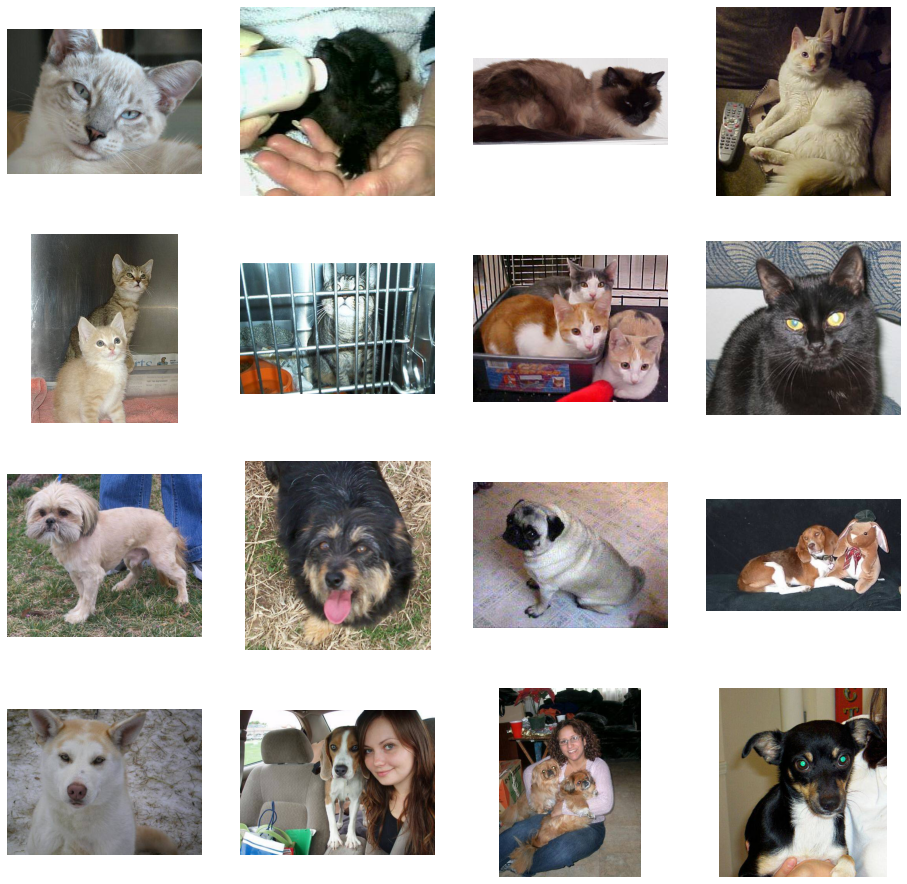

In [49]:
import matplotlib.image as mpi

nrows=4
ncols=4

fig = plt.gcf()
fig.set_size_inches(ncols*4,nrows*4)

img_index=200

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

next_cat_img = [os.path.join(train_cats_dir,fname) for fname in train_cat_fnames[img_index-8:img_index]]

next_dog_img = [os.path.join(train_dogs_dir,fname) for fname in train_dog_fnames[img_index-8:img_index]]

for i , img_path in enumerate(next_cat_img+next_dog_img):

  ## Get sub plots
  sp = plt.subplot(nrows,ncols,i + 1)
  sp.axis('Off')

  img = mpi.imread(img_path)
  plt.imshow(img)

plt.show()

### Pre trained models for Image Classification

In this section, we cover 4 pre-trained models for image classification as follows.

## VGG16

VGG16 is one of the most popular pre-trained models for image classification and developed at the Visual Graphics Group at the University of Oxford. VGG16 is beat the standard AlexNet.

Here is the architecture of VGG16,


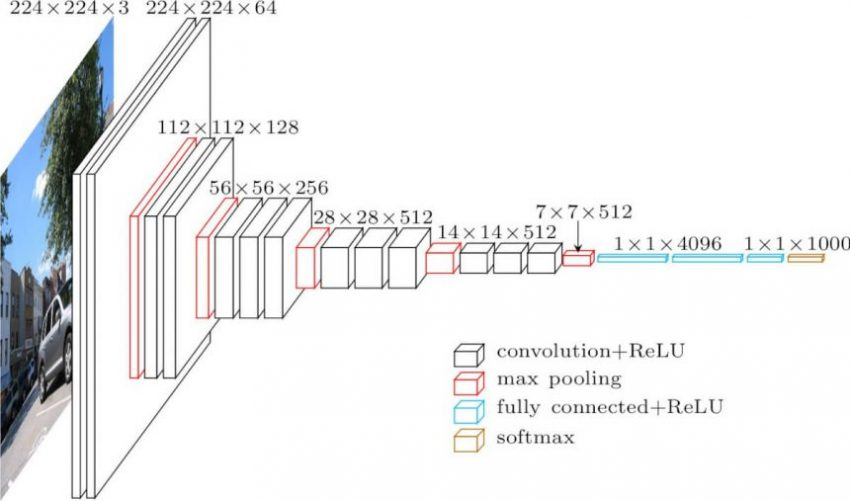

Here, is a more intuitive layout of the VGG16 model,

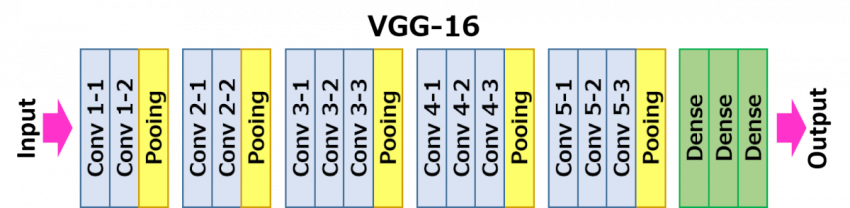

Source: [Very Deep Convolutional Networks for Large Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf)

The layers of the model as follows,

1. Convolutional Layers = 13

2. Pooling Layers = 5

3. Dense Layers = 3

The number of parameters for VGG16 model is 138 Billlion.Due to this it's a slower and much larger model to train than others. 

Now, we will explore how to train a VGG16 model on our dataset.

### Step 1 : Image Augmentation

In [50]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
valid_datagen = ImageDataGenerator(rescale = 1.0/255.)


### Step 2 : Training and Validation Sets

In [51]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

# Flow validation images in batches of 20 using valid_datagen generator
valid_generator = valid_datagen.flow_from_directory(valid_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Step 3 : Loading the Base Model

In [52]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

## Since we don't want to train all the layers

for layer in base_model.layers:
    layer.trainable = False

### Compile and Fit

In [53]:
# Flatten the output layer to 1 dimension
x = Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)

# Add a dropout rate of 0.4
x = Dropout(0.4)(x)

# Add a final sigmoid layer with 1 node for classification output
x = Dense(1, activation='sigmoid')(x)

model = Model(base_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.0002), loss = 'binary_crossentropy',metrics = ['acc'])

In [54]:
vgghist = model.fit(train_generator, validation_data = valid_generator, steps_per_epoch = 100, epochs = 10)


Epoch 1/10
100/100 [==============================] - 36s 355ms/step - loss: 0.8621 - acc: 0.6485 - val_loss: 0.4640 - val_acc: 0.7610
Epoch 2/10
100/100 [==============================] - 35s 347ms/step - loss: 0.4778 - acc: 0.7615 - val_loss: 0.4985 - val_acc: 0.7670
Epoch 3/10
100/100 [==============================] - 35s 349ms/step - loss: 0.4245 - acc: 0.8000 - val_loss: 0.2347 - val_acc: 0.9010
Epoch 4/10
100/100 [==============================] - 36s 361ms/step - loss: 0.4030 - acc: 0.8105 - val_loss: 0.2609 - val_acc: 0.8860
Epoch 5/10
100/100 [==============================] - 35s 348ms/step - loss: 0.3783 - acc: 0.8305 - val_loss: 0.3322 - val_acc: 0.8600
Epoch 6/10
100/100 [==============================] - 35s 349ms/step - loss: 0.3761 - acc: 0.8340 - val_loss: 0.1956 - val_acc: 0.9290
Epoch 7/10
100/100 [==============================] - 35s 347ms/step - loss: 0.3478 - acc: 0.8435 - val_loss: 0.2008 - val_acc: 0.9160
Epoch 8/10
100/100 [==============================] - 3

### Plot the Accuracy and loss during the fine tuning the pre-trained models.

In [55]:
def plot_accuracy_loss(history):
  """
  Plot the Accuracy and loss during the fine tuning the pre-trained models.
  """

  fig = plt.figure(figsize=(10,6))

  ## Plot accuracy
  plt.subplot(221)
  plt.plot(history.history['acc'],'ro--',label='train_acc')
  plt.plot(history.history['val_acc'],'bo--',label = 'val_acc')
  plt.title("train_acc vs val_acc")
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

  ## Plot loss
  plt.subplot(222)
  plt.plot(history.history['loss'],'ro--',label='train_loss')
  plt.plot(history.history['val_loss'],'bo--',label = 'val_loss')
  plt.title("train_loss vs val_loss")
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.show()

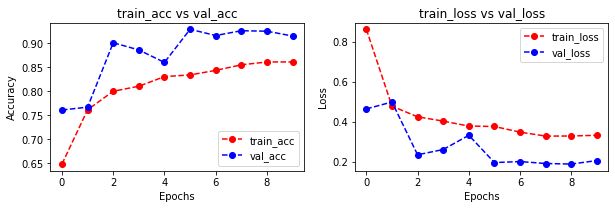

In [56]:
plot_accuracy_loss(vgghist)

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Model performance on new data

In [57]:
cat_img = cv2.imread('/content/drive/MyDrive/cat_dog/cat_test.jpeg')
cat_img = cv2.resize(cat_img,(224,224))
cat_img = np.reshape(cat_img,[1,224,224,3])

classes = model.predict(cat_img)

print(classes)

[[0.]]


In [58]:
dog_img = cv2.imread('/content/drive/MyDrive/cat_dog/dog_test.webp')
dog_img = cv2.resize(dog_img,(224,224))
dog_img = np.reshape(dog_img,[1,224,224,3])

classes = model.predict(dog_img)

print(classes)

[[1.]]


## Inception

Inception model is developed by Google. The orignal paper proposed the Inceptionv1 Model. It has only 7 billion parameters and it was smaller than the VGG16 and AlexNet. It also has a lower error rate but the major breakthrough in this paper was the Inception Module. 

The Inception module just performs convolutions with different filter sizes on the input, performs Max Pooling and concatenates the result for next Inception module and the introduction of the 1*1 convolution operation reduces the parameters drastically.

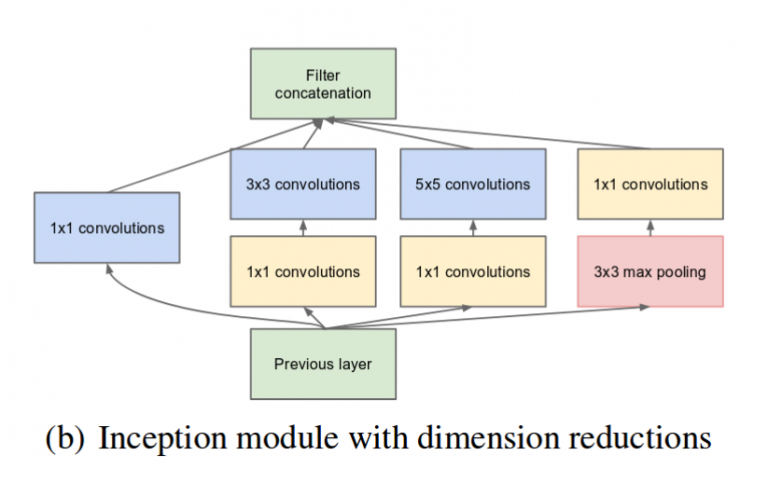

The number of layers in Inceptionv1 is 22. Let us check Inception module.

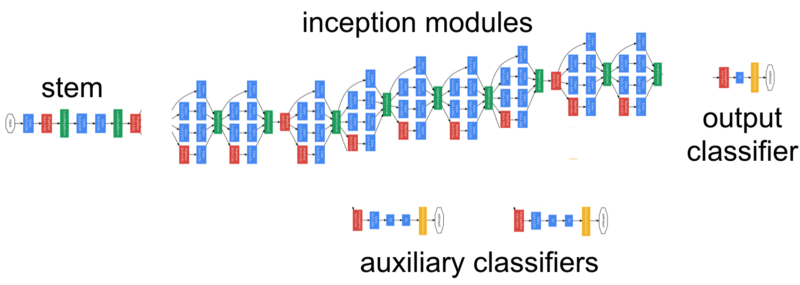




The inceptionv2 model was major improvement on the inceptionv1 model which increased the accuracy and made the model less complex. 

The following major improvements are included for Inceptionv3:

1. Introduction of Batch Normalisation

2. More factorization

3. RMSProp Optimiser





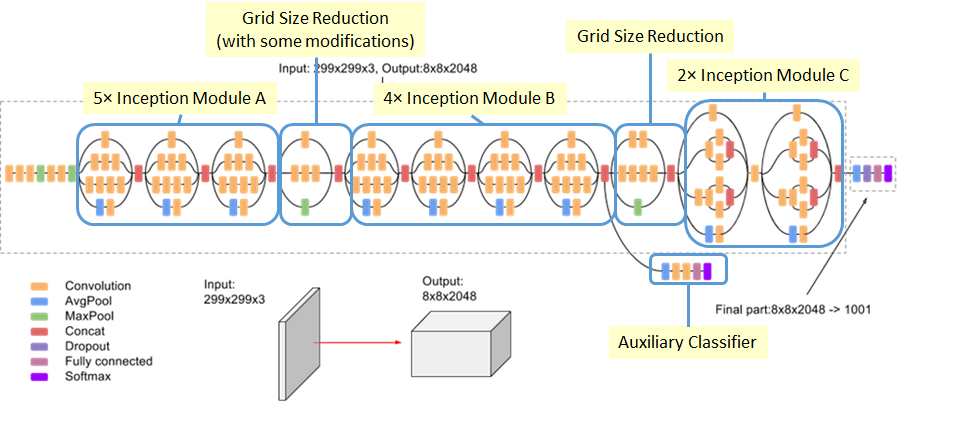

Source : [Going Deeper with Convolutions](https://arxiv.org/abs/1409.4842)

### Step 1 : Loading the Base Model

In [59]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

## Just like VGG16, we will only change the last layer.

for layer in base_model.layers:
    layer.trainable = False

### Step 2 : Compile and Fit

In [60]:
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = Dense(1, activation='sigmoid')(x)

model = Model(base_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.0005), loss = 'binary_crossentropy', metrics = ['acc'])

In [61]:
inchist = model.fit(train_generator, validation_data = valid_generator, steps_per_epoch = 100, epochs = 10)

Epoch 1/10
100/100 [==============================] - 36s 321ms/step - loss: 6.3591 - acc: 0.8995 - val_loss: 0.4616 - val_acc: 0.9810
Epoch 2/10
100/100 [==============================] - 31s 315ms/step - loss: 1.4760 - acc: 0.9490 - val_loss: 0.2577 - val_acc: 0.9860
Epoch 3/10
100/100 [==============================] - 31s 306ms/step - loss: 1.4492 - acc: 0.9445 - val_loss: 0.3843 - val_acc: 0.9830
Epoch 4/10
100/100 [==============================] - 31s 307ms/step - loss: 0.8601 - acc: 0.9515 - val_loss: 0.2498 - val_acc: 0.9840
Epoch 5/10
100/100 [==============================] - 31s 305ms/step - loss: 0.6292 - acc: 0.9640 - val_loss: 0.1420 - val_acc: 0.9860
Epoch 6/10
100/100 [==============================] - 31s 305ms/step - loss: 0.4603 - acc: 0.9615 - val_loss: 0.1973 - val_acc: 0.9840
Epoch 7/10
100/100 [==============================] - 30s 303ms/step - loss: 0.4531 - acc: 0.9645 - val_loss: 0.2015 - val_acc: 0.9890
Epoch 8/10
100/100 [==============================] - 3

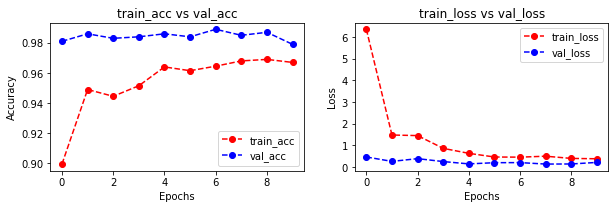

In [62]:
plot_accuracy_loss(inchist)

### Model performance on new data

In [63]:
cat_img = cv2.imread('/content/drive/MyDrive/cat_dog/cat_test.jpeg')
cat_img = cv2.resize(cat_img,(224,224))
cat_img = np.reshape(cat_img,[1,224,224,3])

classes = model.predict(cat_img)

print(classes)

[[1.]]


In [64]:
dog_img = cv2.imread('/content/drive/MyDrive/cat_dog/dog_test.webp')
dog_img = cv2.resize(dog_img,(224,224))
dog_img = np.reshape(dog_img,[1,224,224,3])

classes = model.predict(dog_img)

print(classes)

[[1.]]


## ResNet50

The main motivation is behind ResNet50 model was to avoid poor accuracy, as the model went on to become deeper and also it will tackle vanishing gradient issue. 

Let us check architecture of ResNet34(which is similar to ResNet50 having more layers)

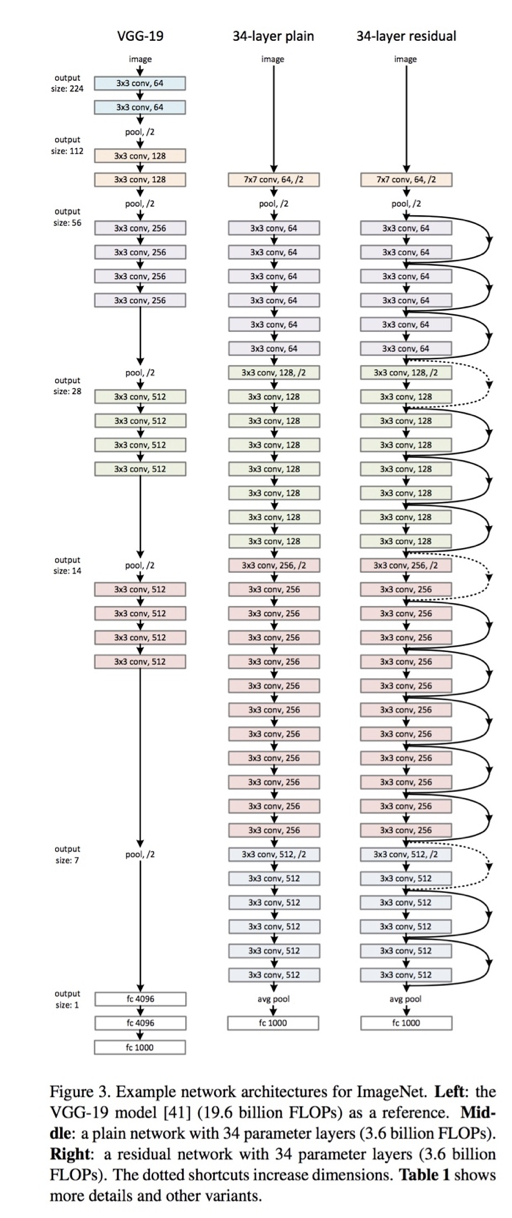

Source : [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385v1.pdf)

The main concept behind ResNet models was that after every 2 convolutions, we are bypassing/skipping layer in between. These skipped connections are called "Residual blocks" or "Identity shortcut connections". 

The ResNet50 is among the most popular models out all ResNet family.

Let us we use ResNet50 for our dataset.

### Loading the baseline model

In [65]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")

## Just like VGG16 and Inception, we will only change the last layer.

for layer in base_model.layers:
    layer.trainable = False


### Build and compile model

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D

base_model = Sequential()
base_model.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
base_model.add(Dense(1, activation='sigmoid'))

base_model.compile(optimizer = SGD(learning_rate=0.0004), loss = 'binary_crossentropy', metrics = ['acc'])


In [68]:
resnethist = base_model.fit(train_generator, validation_data = valid_generator, steps_per_epoch = 100, epochs = 10)

Epoch 1/10
100/100 [==============================] - 38s 379ms/step - loss: 0.5111 - acc: 0.8675 - val_loss: 1.6487 - val_acc: 0.5020
Epoch 2/10
100/100 [==============================] - 37s 369ms/step - loss: 0.2934 - acc: 0.9245 - val_loss: 2.6861 - val_acc: 0.4990
Epoch 3/10
100/100 [==============================] - 37s 374ms/step - loss: 0.2690 - acc: 0.9305 - val_loss: 3.0892 - val_acc: 0.5060
Epoch 4/10
100/100 [==============================] - 38s 377ms/step - loss: 0.2040 - acc: 0.9485 - val_loss: 2.0971 - val_acc: 0.5200
Epoch 5/10
100/100 [==============================] - 38s 383ms/step - loss: 0.2077 - acc: 0.9485 - val_loss: 2.2542 - val_acc: 0.5320
Epoch 6/10
100/100 [==============================] - 37s 370ms/step - loss: 0.1654 - acc: 0.9570 - val_loss: 2.3884 - val_acc: 0.6090
Epoch 7/10
100/100 [==============================] - 37s 369ms/step - loss: 0.1929 - acc: 0.9510 - val_loss: 1.4389 - val_acc: 0.7500
Epoch 8/10
100/100 [==============================] - 3

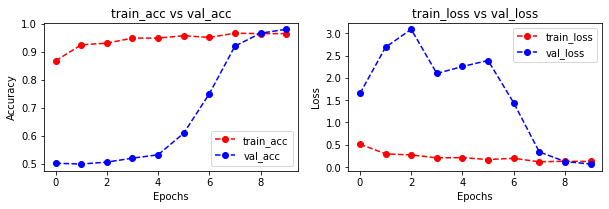

In [69]:
plot_accuracy_loss(resnethist)

### Model performance on new data

In [70]:
cat_img = cv2.imread('/content/drive/MyDrive/cat_dog/cat_test.jpeg')
cat_img = cv2.resize(cat_img,(224,224))
cat_img = np.reshape(cat_img,[1,224,224,3])

classes = model.predict(cat_img)

print(classes)

[[1.]]


In [71]:
dog_img = cv2.imread('/content/drive/MyDrive/cat_dog/dog_test.webp')
dog_img = cv2.resize(dog_img,(224,224))
dog_img = np.reshape(dog_img,[1,224,224,3])

classes = model.predict(dog_img)

print(classes)

[[1.]]


## EfficientNet

In EfficientNet, the authors propose a new scaling method called Compound Scaling. The paper proposes that if we scale dimensions by a fixed amount at the same time and do so uniformly, we achieve much better performance and in fact the scaling coefficients can be decided by the user. 

Let us check Baseline EfficientNetB0 model,

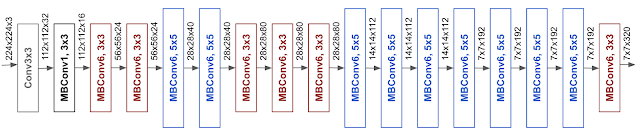

MBConv stands for mobile inverted bottleneck convolution(similar to MobileNetv2).

The following a simple graph showing the comparative performance of EfficientNet family vis-a-vis other popular models.

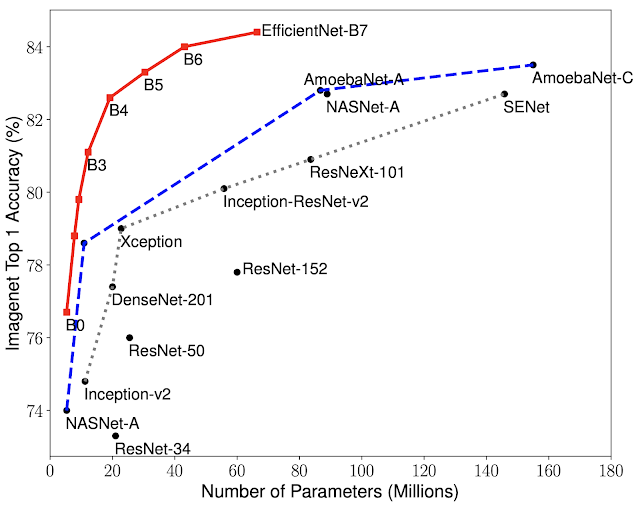

Source : [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/pdf/1905.11946.pdf)